# Read ME



Las datos de [entranamiento](https://drive.google.com/file/d/1tfo6qm8zB5Eb7TY8WQGey-SqwBiC-3uO/view?usp=sharing) y [prueba](https://drive.google.com/file/d/1--yMo6lHVrkU9iqXUjLIJpKLYaz7QfLF/view?usp=sharing) fueron descargados de la plataforma [zoo galaxy](https://data.galaxyzoo.org/#section-21) correspondientes al Galaxy Zoo 2 ([images_gz2.zip](https://zenodo.org/records/3565489#.Y3vFKS-l0eY)).
Dichos datos estan almacenados en formato "[.pkl](https://drive.google.com/drive/folders/1XalRlt11sYmU11op2z3xPnVsRt8Pz0VM?usp=drive_link)" en lugar del formato original de ".jpg" para faciliar el manejor de los mismos. Se trata de la información de 10,000 imagens de entrenamiento y 5,000 de prueba. La información se encuentra reducida a 75 pixles por imagenes siendo de 5x5 pixeles en tress canales de color. Para poder observar la galaxia es precsiso recosntruir la imagen

# Set up

## Packages

In [1]:
!pip install hdbscan

In [2]:
# Mount Google Drive to access and store files
# Comment out this cell if running the script locally

from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Force remount to ensure access


Mounted at /content/drive


In [3]:
import os
import io

import time

import math
import h5py
import random

import requests

import numpy as np
import matplotlib.pyplot as plt

# Machine learning tools for feature reduction and data scaling
from sklearn.decomposition import IncrementalPCA  # Performs incremental PCA for large datasets
from sklearn.preprocessing import StandardScaler  # Standardizes data before applying PCA
import joblib                                     # For saving and loading machine learning models


In [4]:
# Import HDBSCAN for density-based clustering
import hdbscan

# Import cosine distance metric for measuring similarity between data points
from sklearn.metrics.pairwise import cosine_distances


## Funtions

In [22]:
def load_data(data='train'):
    """
    Downloads and loads preprocessed training or testing data from Google Drive.

    Parameters:
    - data (str): Specifies which dataset to load ('train' or 'test').

    Returns:
    - DATA (numpy array or None): The loaded dataset if successful, otherwise None.
    """

    # Define Google Drive file IDs for train and test datasets
    if data.lower() == 'train':
        file_id = '1-8JHObeY7kaU0qLt0p7WDFRJf6A6iYFN'  # File ID for training data

    elif data.lower() == 'test':
        file_id = '1bdjlyKp02O04uGkixX1E4mQMkUjvWRbL'  # File ID for test data

    else:
        print('Error: Type of data invalid')  # Handle incorrect input
        return None

    # Construct the download URL
    url = f"https://drive.google.com/uc?export=download&id={file_id}"

    # Request file from Google Drive
    respuesta = requests.get(url)

    # Load the file as a byte stream
    file_stream = io.BytesIO(respuesta.content)

    # Load the dataset using joblib
    DATA = joblib.load(file_stream)

    # Confirm successful data loading
    print(f'{data.lower()} data loaded\nShape: {DATA.shape}')

    return DATA




def single_reconverter(data):
    """
    Takes a single PCA-transformed data point, reverses the PCA and scaling transformations,
    and normalizes it before reshaping it into an image.

    Parameters:
    - data (numpy array): A single data point in PCA-reduced form.

    Returns:
    - norm_centroides (numpy array): Reconstructed image (174x174x3).
    """
    data = data.reshape(1, -1)  # Ensure data is a 2D array
    centroides = scaler.inverse_transform(data)  # Reverse standard scaling
    centroides = ipca.inverse_transform(centroides)  # Reverse PCA transformation
    norm_centroides = normalized(centroides)  # Normalize pixel values
    norm_centroides = norm_centroides.reshape(174, 174, 3)  # Reshape into an image
    return norm_centroides


def reconverter(data):
    """
    Reconstructs multiple PCA-reduced data points back into images.

    Parameters:
    - data (numpy array): Multiple PCA-transformed data points.

    Returns:
    - norm_centroides (numpy array): Reconstructed images with normalized pixel values.
    """
    centroides = scaler.inverse_transform(data)  # Reverse scaling
    centroides = ipca.inverse_transform(centroides)  # Reverse PCA
    norm_centroides = normalized(centroides)  # Normalize pixel values
    return norm_centroides


def normalized(data):
    """
    Normalizes data to the range [0,1] using min-max scaling.

    Parameters:
    - data (numpy array): Input data.

    Returns:
    - norm (numpy array): Normalized data.
    """
    norm = (data - data.min()) / (data.max() - data.min())  # Min-max normalization
    return norm

def histogram(labels, clusters, name):
    """
    Plots a histogram of cluster distribution with a semi-logarithmic scale.

    Parameters:
    - labels (array-like): Cluster assignments for each sample.
    - bins (int or sequence): Number of bins or bin edges for the histogram.
    - name (str): File name for saving the plot.

    Returns:
    - None
    """

    # Define bin edges for the histogram, covering all cluster indices
    bins = np.arange(-1,clusters)

    # Set up the figure size for better visualization
    plt.figure(figsize=(15, 4))

    # Set the title of the plot
    plt.title('Distribution for Each Cluster')

    # Use a semi-logarithmic scale to highlight differences in frequency
    plt.semilogy()

    # Plot a histogram showing the frequency of samples in each cluster
    frecuencia, clases, _ = plt.hist(labels, bins=bins, rwidth=0.8)

    # Label the axes
    plt.xlabel('Cluster')
    plt.ylabel('Frequency')

    # Set cluster numbers as x-axis ticks (centered between bins)
    plt.xticks(bins[:-1] + 0.5, bins[:-1])

    # Add a grid along the y-axis for better readability
    plt.grid(axis='y')

    # Adjust layout to prevent overlapping elements
    plt.tight_layout()

    # Save the figure as a PDF file in the results directory
    plt.savefig(f'{root_result}{name}.pdf')

    # Display the plot
    plt.show()

    return None

## Directories

In [6]:
### Drive roots ####

root_train ='/content/drive/MyDrive/Practicas_Profesionales/Data/PKLs/train_data.pkl'
root_test ='/content/drive/MyDrive/Practicas_Profesionales/Data/PKLs/test_data.pkl'

root_ipca = '/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/reduce_dimensions.pkl'
root_scaler = '/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/scaler.pkl'

root_result = '/content/drive/MyDrive/Practicas_Profesionales/Results/HDB/'

In [7]:
# ### Local roots ####

# root_train ='/home/tonathiu/Fisica/Practicas_Profesionales/Data/train_data.pkl'
# root_test ='/home/tonathiu/Fisica/Practicas_Profesionales/Data/test_data.pkl'

# root_ipca = '/home/tonathiu/Fisica/Practicas_Profesionales/Codes/Models/Pre-processing/reduce_dimensions.pkl'
# root_scaler = '/home/tonathiu/Fisica/Practicas_Profesionales/Codes/Models/Pre-processing/scaler.pkl'

# root_result = '/home/tonathiu/Fisica/Practicas_Profesionales/Results/HDB/'

## Load Models

In [8]:
ipca = joblib.load(root_ipca)
scaler = joblib.load(root_scaler)

## Load Train Data

In [9]:
#train_data = joblib.load(root_train)

train_data = load_data('train')

# Compute pairwise cosine distances for the training data

train_cosine_dist = cosine_distances(train_data)

train data loaded
Shape: (10000, 75)


## Load Test Data

In [10]:
#test_data = joblib.load(root_test)
test_data = load_data('test')

# Compute pairwise cosine distances for the training data

test_data_cosine = cosine_distances(test_data)

test data loaded
Shape: (5000, 75)


# [HDBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html)

In [11]:
# Initialize HDBSCAN clustering with precomputed cosine distances

hdb = hdbscan.HDBSCAN(
    metric='precomputed',  # Use a precomputed distance matrix (cosine distance)
    min_cluster_size=6,  # Minimum number of points required to form a cluster
    cluster_selection_epsilon=0.3,  # Controls the minimum separation between clusters
    cluster_selection_method="leaf",  # Selects clusters from the most refined partition
    gen_min_span_tree=True  # Generates the minimum spanning tree for visualization
)

# Fit the HDBSCAN model to the precomputed cosine distance matrix
hdb.fit(train_cosine_dist)  # Ensure that 'train_cosine_dist' contains pairwise distances


HDBSCAN(cluster_selection_epsilon=0.3, cluster_selection_method='leaf',
        gen_min_span_tree=True, metric='precomputed', min_cluster_size=6)

## Arbol de densidades

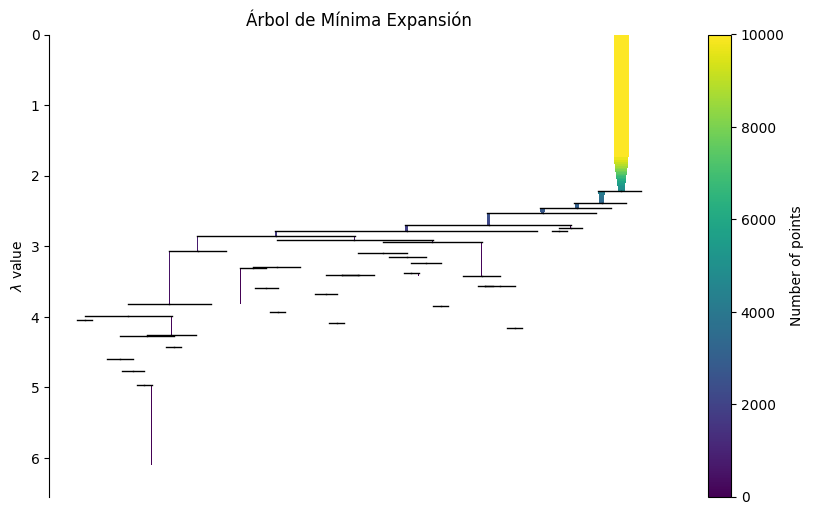

In [12]:
# Create a figure for visualizing the hierarchical clustering tree
plt.figure(figsize=(10, 6))

# Plot the condensed hierarchical tree generated by HDBSCAN
hdb.condensed_tree_.plot()

# Set the title for the plot
plt.title("Árbol de Mínima Expansión")

plt.savefig(f'{root_result}Arbol_de_minima_expansion_HDB.pdf')

# Display the tree plot
plt.show()


## Clasification

In [13]:
# Predict cluster labels for the test dataset using the trained HC model

labels = hdb.labels_

# Obtain the number of clusters

clusters = len(np.unique(labels))

## Histogram

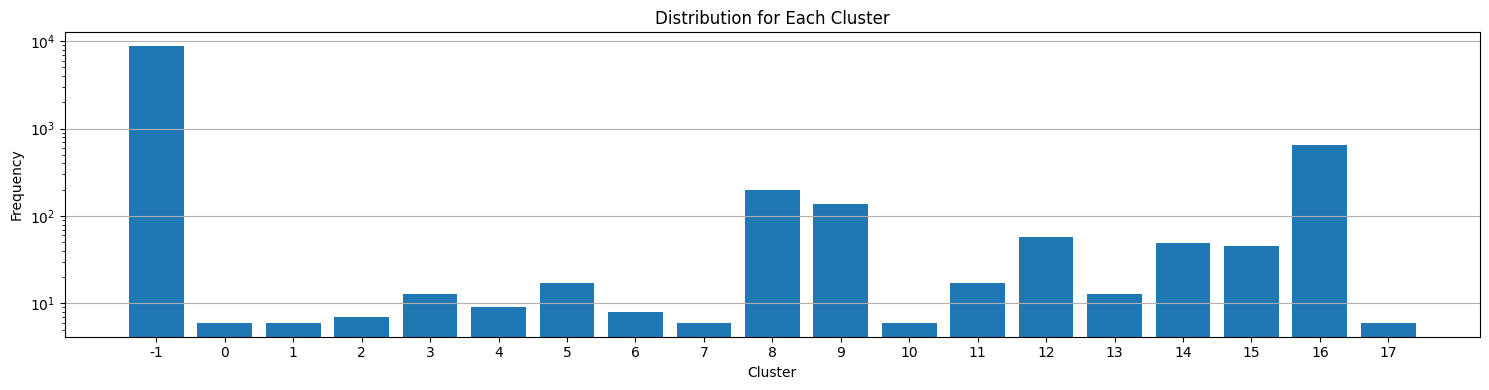

In [21]:
histogram(labels, clusters, 'Histograma_HDB')

## Centroids

In [ ]:
# Get unique cluster labels from the test data predictions

etiquetas = np.unique(labels)


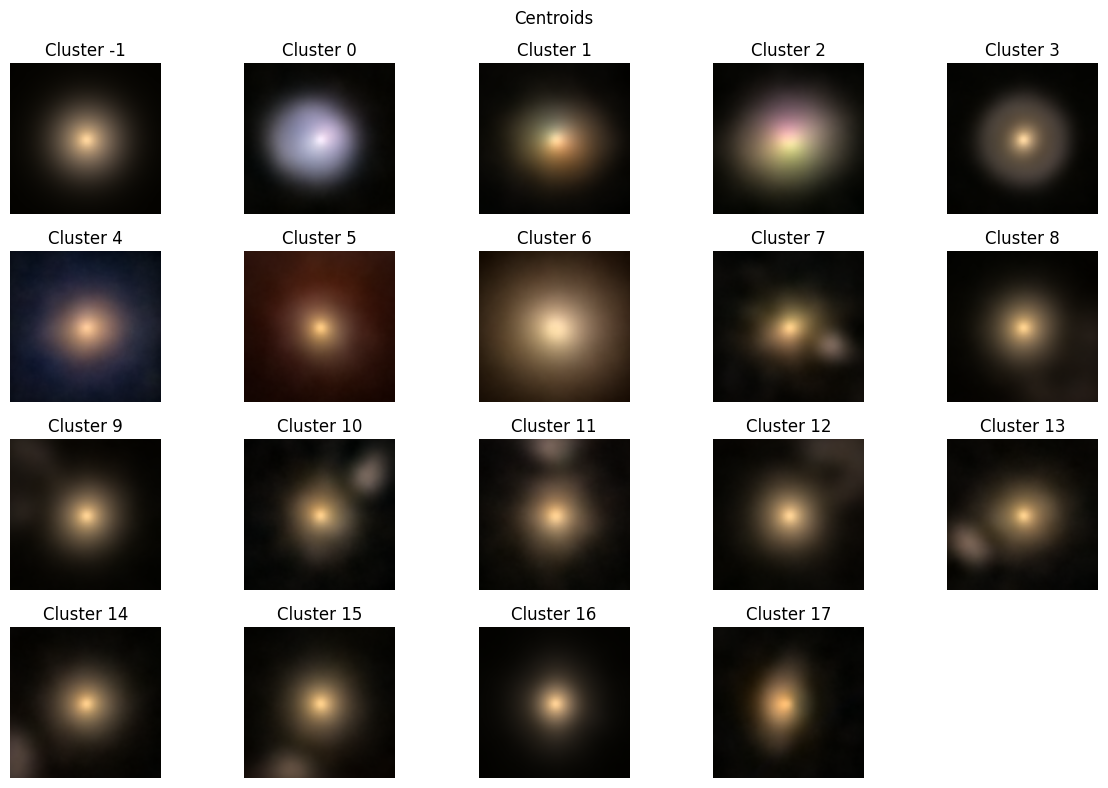

In [ ]:
# Create a figure to visualize cluster centroids
plt.figure(figsize=(12, 8))

# Determine the number of rows needed for the subplot grid
filas = math.ceil(len(etiquetas) / 5)

# Iterate over each cluster label
for clus in etiquetas:
    centroides = []  # List to store all data points in the cluster

    # Collect all samples belonging to the current cluster
    for i in range(len(labels)):
        if labels[i] == clus:
            centroides.append(train_data[i])  # Append PCA-transformed sample

    # Compute the mean (centroid) of all points in the cluster
    center = np.mean(centroides, axis=0)

    # Convert the centroid back to an image format
    img = single_reconverter(center)

    # Plot the centroid image in a grid, adjusting for correct indexing
    plt.subplot(filas, 5, clus + 2)  # Ensure subplot index starts from 1
    plt.imshow(img)

    # Set the cluster label as the title
    plt.title(f'Cluster {clus}')
    plt.axis('off')  # Hide axes for a cleaner visualization

# Set a global title for the figure
plt.suptitle('Centroids')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig(f'{root_result}Centroides_HDB.pdf')
# Display the visualization
plt.show()


In [ ]:
# Initialize subplot index
ploteo = 1

# Create a figure with dynamic height based on the number of clusters
plt.figure(figsize=(10, 3 * clusters))

# Iterate over each unique cluster label
for etq in etiquetas:
    cuenta = 0  # Counter to limit the number of images per cluster

    # Loop through all samples in the dataset
    for i in range(len(labels)):

        # Select images that belong to the current cluster
        if etq == labels[i]:
            cuenta += 1  # Count images plotted for the cluster

            # Convert the PCA-transformed sample back to an image
            img = single_reconverter(train_data[i])

            # Plot the image in a grid (clusters x 5 layout)
            plt.subplot(clusters, 5, ploteo)
            plt.imshow(img)
            plt.axis('off')  # Hide axis for cleaner visualization

            # Set a title for the third image in each cluster
            if cuenta == 3:
                plt.title(f'Cluster {etq}')

            ploteo += 1  # Increment subplot index

        # Stop after plotting 5 images per cluster
        if cuenta == 5:
            break

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig(f'{root_result}Clusters_HDB.pdf')
# Display the figure
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Initialize subplot index
ploteo = 1

# Create a figure with dynamic height based on the number of clusters
plt.figure(figsize=(10, 3 * clusters))


# Loop through all samples in the dataset
for i in range(len(labels)):
    # Select images that belong to the current cluster
    if etiquetas[0] == labels[i]:
        cuenta += 1  # Count images plotted for the cluster

        # Convert the PCA-transformed sample back to an image
        img = single_reconverter(train_data[i])

        # Plot the image in a grid (clusters x 5 layout)
        plt.subplot(clusters, 5, ploteo)
        plt.imshow(img)
        plt.axis('off')  # Hide axis for cleaner visualization


        ploteo += 1  # Increment subplot index

    # Stop after plotting 5 images per cluster
    if ploteo > int(clusters*5):
        break
plt.suptitle('Cluster ruido', y=1.00003)
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig(f'{root_result}Exploracion_ruido_HDB.pdf')
# Display the figure
plt.show()


Output hidden; open in https://colab.research.google.com to view.